<a href="https://www.kaggle.com/code/hongtptrai/big-data?scriptVersionId=289008970" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

**Library and Initial Enviroment**

In [1]:
import shutil
import subprocess
import os
import sys
import io
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import time
from PIL import Image
from torchvision.transforms import Compose
from pyspark.sql.functions import col 
from pyspark.sql import SparkSession
from pyspark import TaskContext

print("=== BẮT ĐẦU SETUP ===")

# --- 1. CLONE REPO ---
repo_dir = "/kaggle/working/Depth-Aware-Editing"

should_clone = False
if not os.path.exists(repo_dir):
    should_clone = True
elif not os.listdir(repo_dir):
    should_clone = True

if should_clone:
    print("1. Đang Clone Repo 'Depth-Aware-Editing'...")
    subprocess.run(["git", "clone", "https://github.com/rishubhpar/Depth-Aware-Editing", repo_dir])
else:
    print("1. Repo chính đã có và không rỗng.")

# --- 2. SETUP DINOv2 ---
hub_dir = "/kaggle/working/torchhub"
dinov2_path = os.path.join(hub_dir, "facebookresearch_dinov2_main")

if not os.path.exists(dinov2_path):
    print("2. Đang cài đặt DINOv2...")
    os.makedirs(hub_dir, exist_ok=True)
    subprocess.run(["wget", "-q", "-O", "dinov2.zip", "https://github.com/facebookresearch/dinov2/archive/refs/heads/main.zip"])
    subprocess.run(["unzip", "-q", "-o", "dinov2.zip", "-d", hub_dir])
    
    extracted_path = os.path.join(hub_dir, "dinov2-main")
    if os.path.exists(extracted_path):
        if os.path.exists(dinov2_path):
            shutil.rmtree(dinov2_path)
        os.rename(extracted_path, dinov2_path)
    
    if os.path.exists("dinov2.zip"):
        os.remove("dinov2.zip")
    print("   -> DINOv2 Ready.")
else:
    print("2. DINOv2 đã có sẵn.")

# --- 3. WEIGHTS DOWLOAD ---
weights_dir = os.path.join(repo_dir, "weights")
os.makedirs(weights_dir, exist_ok=True)
weights_path = os.path.join(weights_dir, "depth_anything_vits14.pth")
url = "https://huggingface.co/spaces/LiheYoung/Depth-Anything/resolve/main/checkpoints/depth_anything_vits14.pth"

if os.path.exists(weights_path):
    if os.path.getsize(weights_path) < 1_000_000:
        os.remove(weights_path)

if not os.path.exists(weights_path):
    print("3. Đang tải Weights (VITS)...")
    subprocess.run(["curl", "-L", "-o", weights_path, url])

if os.path.exists(weights_path) and os.path.getsize(weights_path) > 1_000_000:
    sz = os.path.getsize(weights_path) / (1024 * 1024)
    print(f"✅ SETUP HOÀN TẤT! Weights: {sz:.2f} MB")
else:
    print("❌ Lỗi tải Weights. Hãy kiểm tra Internet!")

=== BẮT ĐẦU SETUP ===
1. Đang Clone Repo 'Depth-Aware-Editing'...


Cloning into '/kaggle/working/Depth-Aware-Editing'...


2. Đang cài đặt DINOv2...
   -> DINOv2 Ready.
3. Đang tải Weights (VITS)...


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1335  100  1335    0     0   7786      0 --:--:-- --:--:-- --:--:--  7807


✅ SETUP HOÀN TẤT! Weights: 94.62 MB


100 94.6M  100 94.6M    0     0   134M      0 --:--:-- --:--:-- --:--:--  329M


In [2]:
!rm -rf /kaggle/working/depth_output
!mkdir -p /kaggle/working/depth_output

CONFIG = {
    "REPO_PATH": "/kaggle/working/Depth-Aware-Editing/src/Depth-Anything",
    
    "INPUT_DATA_PATH": "/kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_train/*", 
    
    "OUTPUT_DATA_PATH": "/kaggle/working/depth_output",
}

if not os.path.exists(CONFIG["OUTPUT_DATA_PATH"]):
    os.makedirs(CONFIG["OUTPUT_DATA_PATH"])

**Core Logic**

In [3]:
def reduce_process_partition(iterator):
    import shutil
    import subprocess
    import os
    import sys
    import io
    import torch
    import torch.nn.functional as F
    import numpy as np
    import cv2
    import time
    from PIL import Image
    from torchvision.transforms import Compose
    from pyspark import TaskContext
    import random

    time.sleep(random.uniform(0.5, 3.0))
    
    repo_path = "/kaggle/working/Depth-Aware-Editing/src/Depth-Anything"
    if repo_path not in sys.path: sys.path.append(repo_path)
    
    try:
        from depth_anything.dpt import DepthAnything
        from depth_anything.util.transform import Resize, NormalizeImage, PrepareForNet
    except:
        sys.path.append("/kaggle/working/Depth-Aware-Editing/Depth-Anything")
        from depth_anything.dpt import DepthAnything
        from depth_anything.util.transform import Resize, NormalizeImage, PrepareForNet

    ctx = TaskContext.get()
    part_id = ctx.partitionId()
    
    if torch.cuda.is_available():
        gpu_id = part_id % torch.cuda.device_count()
        device = torch.device(f"cuda:{gpu_id}")
    else:
        device = torch.device("cpu")

    depth_model = None
    config = { "encoder": "vits", "features": 64, "out_channels": [48, 96, 192, 384], "use_bn": False, "use_clstoken": False }
    
    for attempt in range(3):
        try:
            torch.cuda.empty_cache()
            model = DepthAnything(config)
            depth_model = model.to(device).eval()
            break 
        except Exception:
            time.sleep(2)
            continue

    if depth_model is None:
        return iter([(f"Error_{part_id}", "Model Load Failed")])

    ckpt = "/kaggle/working/Depth-Aware-Editing/weights/depth_anything_vits14.pth"
    if os.path.exists(ckpt):
        depth_model.load_state_dict(torch.load(ckpt, map_location=device), strict=False)

    transform = Compose([
        Resize(width=518, height=518, resize_target=False, keep_aspect_ratio=True, ensure_multiple_of=14, resize_method='lower_bound', image_interpolation_method=cv2.INTER_CUBIC),
        NormalizeImage(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        PrepareForNet(),
    ])
    
    out_dir = "/kaggle/working/depth_output"
    os.makedirs(out_dir, exist_ok=True)
    results = []
    
    BATCH_SIZE = 16
    batch_data, batch_paths, batch_shapes = [], [], []
    count_local = 0 

    def flush_batch():
        if not batch_data: return
        try:
            tensor = torch.from_numpy(np.concatenate(batch_data, axis=0)).to(device)
            with torch.no_grad(): preds = depth_model(tensor)
            
            for i, depth in enumerate(preds):
                h, w = batch_shapes[i]
                d_res = F.interpolate(depth[None, None], (h, w), mode='bilinear', align_corners=False)[0, 0]
                d_np = d_res.cpu().numpy()
                d_norm = (d_np - d_np.min()) / (d_np.max() - d_np.min()) * 255.0
                
                # --- SỬA TÊN FILE ĐỂ TRÁNH TRÙNG ---
                # Lấy tên thư mục cha (ví dụ: 'living_room_001')
                parent_folder = os.path.basename(os.path.dirname(batch_paths[i]))
                # Lấy tên file gốc (ví dụ: '0005.jpg')
                base_name = os.path.basename(batch_paths[i]).replace(".jpg", "").replace(".png", "")
                
                # Ghép lại: 'living_room_001_0005.png' -> Đảm bảo DUY NHẤT
                fname = f"{parent_folder}_{base_name}.png"
                
                Image.fromarray(d_norm.astype(np.uint8)).save(os.path.join(out_dir, fname))
                results.append((batch_paths[i], "Success"))
        except Exception as e:
            for p in batch_paths: results.append((p, str(e)))

    # --- MAIN LOOP ---
    for key, raw_path in iterator: 
        try:
            # Fix lỗi 'file:' của Spark
            file_path = raw_path.replace("file:", "")
            
            if not os.path.exists(file_path): continue
            
            img = Image.open(file_path).convert("RGB")
            np_img = np.array(img) / 255.0
            
            batch_shapes.append(np_img.shape[:2])
            batch_data.append(transform({'image': np_img})['image'][None])
            batch_paths.append(file_path)
            
            if len(batch_data) >= BATCH_SIZE:
                flush_batch()
                count_local += len(batch_data)
                # Log nhẹ nhàng tiến độ
                if count_local % 100 == 0:
                    print(f"[{part_id}] Processed: {count_local}...") 
                batch_data, batch_paths, batch_shapes = [], [], []
        except: 
            pass
        
    flush_batch()
    return iter(results)

**MapReduce**

In [4]:
def run_job():    
    import random
    
    try: SparkSession.getActiveSession().stop()
    except: pass

    spark = SparkSession.builder \
        .master("local[2]") \
        .appName("Depth_Final_Fixed") \
        .config("spark.driver.memory", "4g") \
        .config("spark.executor.memory", "4g") \
        .config("spark.driver.maxResultSize", "2g") \
        .getOrCreate()

    print(">> Reading Data...")
    # Dataset path của bạn
    CONFIG_INPUT = "/kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_train/*"
    
    df = spark.read.format("binaryFile") \
        .option("recursiveFileLookup", "true") \
        .load(CONFIG_INPUT) \
        .filter(col("path").rlike("(?i).*\\.jpg$")) \
        .select("path") 

    # Kiểm tra xem có bao nhiêu file tìm thấy trước khi chạy
    total_files = df.count()
    print(f">> FOUND: {total_files} images in dataset.")

    NUM_PARTITIONS = 40
    print(f">> ⚡ PIPELINE: Map -> Shuffle -> Reduce ({NUM_PARTITIONS} Partitions)")
    
    def map_assign_key(row):
        key = random.randint(0, NUM_PARTITIONS - 1)
        return (key, row.path)
        
    mapped_rdd = df.rdd.map(map_assign_key)
    partitioned_rdd = mapped_rdd.partitionBy(NUM_PARTITIONS)
    
    count = partitioned_rdd.mapPartitions(reduce_process_partition).count()
    
    print(f">> ✅ DONE! Successfully processed: {count} images.")
    spark.stop()

if __name__ == "__main__":
    run_job()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/29 07:17:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


>> Reading Data...


>> FOUND: 50688 images in dataset.
>> ⚡ PIPELINE: Map -> Shuffle -> Reduce (40 Partitions)


/kaggle/working/torchhub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/kaggle/working/torchhub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/kaggle/working/torchhub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/kaggle/working/torchhub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/kaggle/working/torchhub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
/kaggle/working/torchhub/facebookresearch_dinov2_main/din

>> ✅ DONE! Successfully processed: 50688 images.


**Result**

✅ Đã lấy 5 ảnh mẫu để tìm ảnh gốc...
⏳ Đang tìm ảnh gốc tương ứng (sẽ dừng ngay khi tìm đủ)...


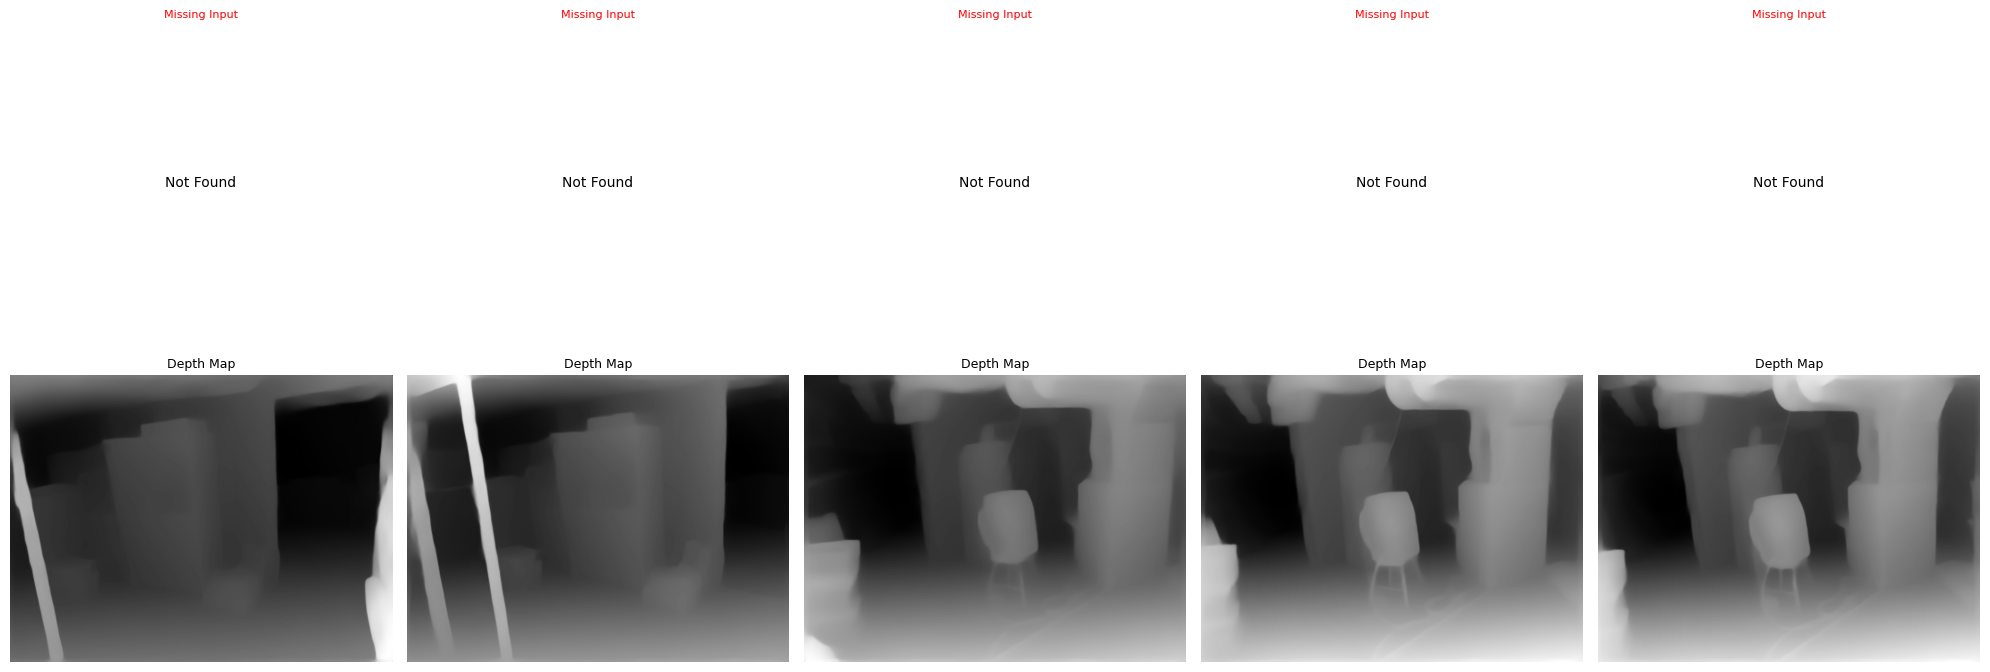

In [5]:
import matplotlib.pyplot as plt
import glob
from PIL import Image
import os

output_dir = "/kaggle/working/depth_output"
input_dir = "/kaggle/input/nyu-depth-v2/nyu_data/data/nyu2_train"

output_paths = sorted(glob.glob(os.path.join(output_dir, "*.png")))[:5] # Chỉ lấy 5 ảnh đầu

if not output_paths:
    print("❌ Không tìm thấy ảnh nào trong folder output!")
else:
    print(f"✅ Đã lấy {len(output_paths)} ảnh mẫu để tìm ảnh gốc...")
    
    targets = {os.path.splitext(os.path.basename(p))[0] for p in output_paths}
    
    input_file_map = {}
    
    print("⏳ Đang tìm ảnh gốc tương ứng (sẽ dừng ngay khi tìm đủ)...")
    for root, dirs, files in os.walk(input_dir):
        for file in files:
            name_no_ext = os.path.splitext(file)[0]
            
            if name_no_ext in targets:
                input_file_map[name_no_ext] = os.path.join(root, file)
                
                if len(input_file_map) == len(targets):
                    print("✅ Đã tìm đủ ảnh gốc. Dừng quét dataset.")
                    break 
        if len(input_file_map) == len(targets):
            break

    num_show = len(output_paths)
    fig, axes = plt.subplots(2, num_show, figsize=(4 * num_show, 7))
    if num_show == 1: axes = axes.reshape(2, 1)

    for i in range(num_show):
        out_path = output_paths[i]
        out_img = Image.open(out_path)
        basename = os.path.splitext(os.path.basename(out_path))[0]
        
        in_path = input_file_map.get(basename)
            
        if in_path and os.path.exists(in_path):
            in_img = Image.open(in_path)
            axes[0, i].imshow(in_img)
            axes[0, i].set_title(f"Input\n{os.path.basename(in_path)}", fontsize=9)
        else:
            axes[0, i].text(0.5, 0.5, "Not Found", ha='center')
            axes[0, i].set_title("Missing Input", fontsize=8, color='red')
        axes[0, i].axis('off')

        axes[1, i].imshow(out_img, cmap='gray')
        axes[1, i].set_title("Depth Map", fontsize=9)
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()